In [1]:
import sys
sys.path.insert(0, '$ATHENA_DIR/vis/python')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pylab import *
import struct
import array
import os
from scipy.interpolate import griddata

# Athena++ modules
import athena_read
import athena_read_select
import h5py

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
filename = 'disk.out1.00089.athdf'

In [3]:
leveln = None
quantities=['rho','press','vel1','vel2','vel3']
with h5py.File(filename, 'r') as f:
      attributes = f.attrs.items()
      attrs = dict(attributes)
      level = f.attrs['MaxLevel']
      time = f.attrs['Time']

subsample = False
if leveln is not None:
    if level > leveln:
        subsample = True
    level = leveln
data = athena_read_select.athdf(filename, quantities=quantities,
    level=level, subsample=subsample)

b'spherical_polar'
[b'prim']
4
[24 10 24]
2608955
6448
[5]
[ 192   80 1032]
[0.65     1.35     1.003814]
[1.4207963 1.7207963 1.       ]
[0.        6.2831855 1.       ]
335.52222
[b'rho' b'press' b'vel1' b'vel2' b'vel3']


In [4]:
thetapos=np.abs(data['x2v']-0.5*np.pi).argmin()

In [5]:
R_Hill = (3e-5 / 3) ** (1/3);

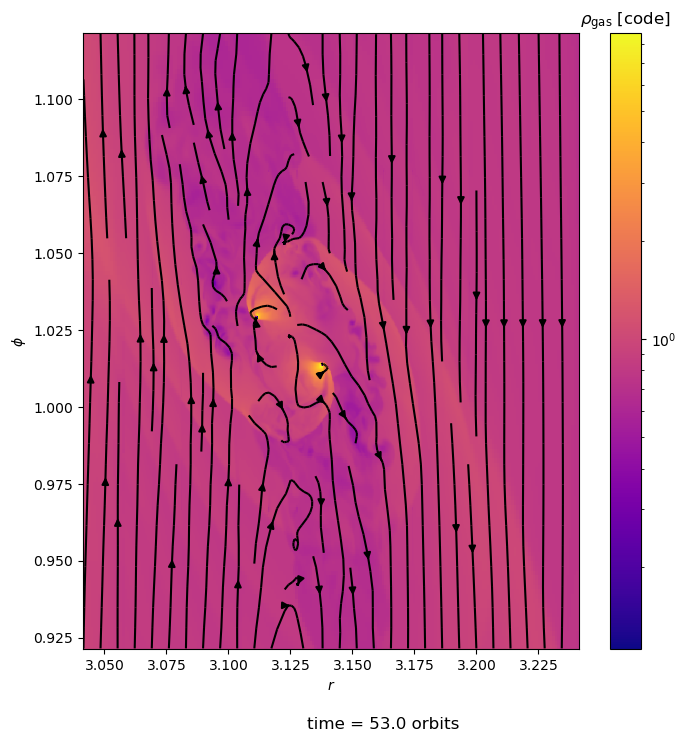

In [8]:
plots, axes = plt.subplots(figsize=(8,8))

plt.ylabel('$\\phi$')
plt.xlabel('$ r$')
minval=min(data['rho'][:,thetapos,:][0])
maxval=max(data['rho'][:,thetapos,:][0])
ridx = np.where(data['x1f'])[0][:-1]
phiidx = np.where(data['x3f'])[0][:-1]

ratex = 20
ratey = 30

U = data['vel1'][:,thetapos,:][phiidx][:,ridx]#.T[::ratex][:,::ratey]
V = data['vel3'][:,thetapos,:][phiidx][:,ridx]#.T[::ratex][:,::ratey]

x = np.linspace(data['x1f'][ridx][0], data['x1f'][ridx][-1],U.shape[0])
y = np.linspace(data['x3f'][phiidx][0], data['x3f'][phiidx][-1],U.shape[1])

X,Y = np.meshgrid(y,x)

norm=matplotlib.colors.LogNorm()
xmesh,zmesh=np.meshgrid(data['x3f'][phiidx],data['x1f'][ridx])

im=axes.pcolormesh(X,Y,data['rho'][:,thetapos,:][phiidx][:,ridx],cmap='plasma', norm=norm)     

cbar=plots.colorbar(im, ax=axes)
cbar.ax.set_title(r"$\rho_{\rm gas}$ [code]")


#  Varying density along a streamline
# plt.quiver(X,Y, U, V, color = 'black')
plt.streamplot(X,Y, U, V, color = 'black')


plt.figtext(0.5, 0.01, 'time = '+str(data['Time'] // (2*np.pi)) + ' orbits', ha="center", fontsize=12)
# plt.title('Zoomed-in density, r and theta')
axes.set_aspect('auto')
#plt.style.use('dark_background')
# plt.savefig('midplane-density.png',transparent=True)
plt.show()

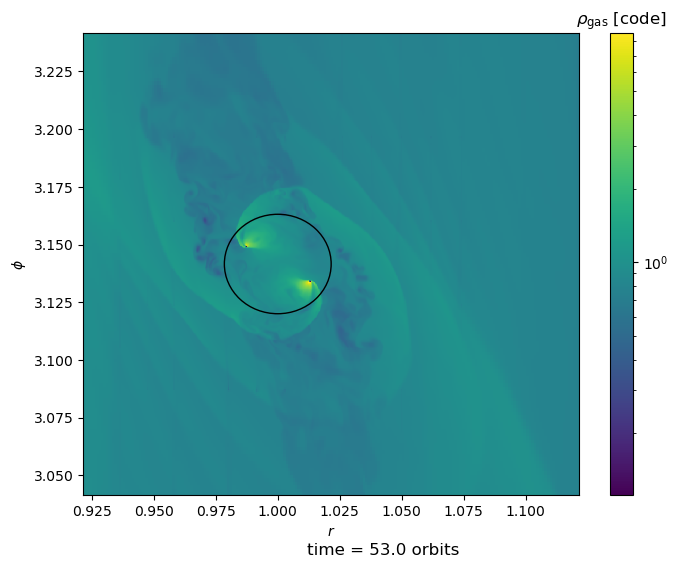

In [40]:
plots, axes = plt.subplots(figsize=(8,6))

plt.ylabel('$\\phi$')
plt.xlabel('$ r$')
minval=min(data['rho'][:,thetapos,:][0])
maxval=max(data['rho'][:,thetapos,:][0])

norm=matplotlib.colors.LogNorm()
# norm=matplotlib.colors.Normalize(vmin=min(data['rho'][-1][thetapos]), vmax=max(data['rho'][-1][thetapos]))
xmesh,zmesh=np.meshgrid(data['x1f'],data['x3f'])
im=axes.pcolormesh(xmesh,zmesh,data['rho'][:,thetapos,:],cmap='viridis', norm=norm)     

cbar=plots.colorbar(im, ax=axes)
cbar.ax.set_title(r"$\rho_{\rm gas}$ [code]")

ratex = 40
ratez = 12

U = data['vel1'][:,thetapos,:].T[::ratex][:,::ratez]
V = data['vel3'][:,thetapos,:].T[::ratex][:,::ratez]

x = np.linspace(data['x1f'][0], data['x1f'][-1], U.shape[0])#[::ratex]
z = np.linspace(data['x3f'][0], data['x3f'][-1], U.shape[1])#[::ratez]

X,Z = np.meshgrid(z,x)

#  Varying density along a streamline
# plt.streamplot(X,Z, U, V, color = 'indigo')
# circle=plt.Circle((1,np.pi), R_Hill, color='black', fill=False)
# axes.add_patch(circle)

plt.figtext(0.5, 0.01, 'time = '+str(data['Time'] // (2*np.pi)) + ' orbits', ha="center", fontsize=12)
# plt.title('Zoomed-in density, r and theta')
axes.set_aspect('auto')
#plt.style.use('dark_background')
# plt.savefig('midplane-density.png',transparent=True)
plt.show()

In [9]:
r = data['x1v']
theta = data['x2v']
phi = data['x3v']

In [10]:
phimesh, thetamesh, rmesh = np.meshgrid(phi, theta, r, indexing='ij')

In [42]:
rp1, thetap1, phip1 = 0.985, np.pi / 2, np.pi
rho = data['rho']
x = rmesh * np.sin(thetamesh) * np.cos(phimesh)
y = rmesh * np.sin(thetamesh) * np.sin(phimesh)
z = rmesh * np.cos(thetamesh)

In [12]:
xp,yp,zp = -1 ,0,0

In [13]:
dist = np.sqrt((x-xp)**2+(y-yp)**2+(z-zp)**2)

In [14]:
import numpy as np

def gravitational_force(x, y, z, body_mass, mesh_coords, earth_mass, gravitational_constant=1):
    # Coordinates of the body
    body_position = np.array([x, y, z])

    # Calculate the distance vector and its magnitude
    r_vector = mesh_coords - body_position
    r_magnitude = np.linalg.norm(r_vector, axis=-1)

    # Unit vector in the direction of the gravitational force
    r_unit_vector = r_vector / r_magnitude[:, :, :, np.newaxis]

    # Calculate the gravitational force
    gravitational_force_magnitude = (gravitational_constant * earth_mass * body_mass) / (r_magnitude**2)

    # Components of the gravitational force
    gravitational_force_components = gravitational_force_magnitude[:, :, :, np.newaxis] * r_unit_vector

    return gravitational_force_components

body_force = gravitational_force(-1, 0, 0, body_mass=3e-5, mesh_coords=np.stack([x, y, z], axis=-1),earth_mass=rho)

# Access components (e.g., gravitational_force_x, gravitational_force_y, gravitational_force_z)
gravitational_force_x = body_force[..., 0]
gravitational_force_y = body_force[..., 1]
gravitational_force_z = body_force[..., 2]


In [15]:
torque_z = (x-xp)*gravitational_force_y + (y-yp)*gravitational_force_x

In [30]:
x.shape

(21,)

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_84412/3135596698.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im=axes.pcolormesh(x[:,thetapos,:],y[:,thetapos,:],torque_z[:,thetapos,:],cmap='PiYG', norm=norm)


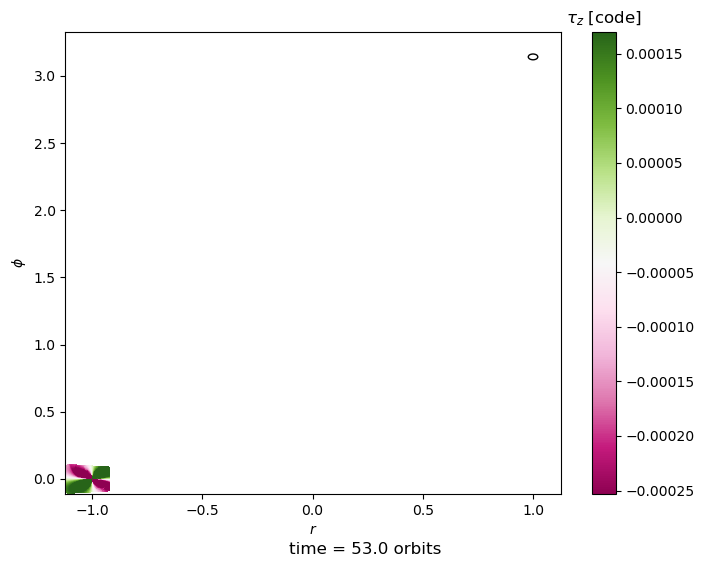

In [35]:
plots, axes = plt.subplots(figsize=(8,6))

plt.ylabel('$\\phi$')
plt.xlabel('$ r$')
minval=min(data['rho'][:,thetapos,:][0])
maxval=max(data['rho'][:,thetapos,:][0])
ridx = np.where(data['x1f'])[0][:-1]
phiidx = np.where(data['x3f'])[0][:-1]

# norm=matplotlib.colors.LogNorm()
norm=matplotlib.colors.Normalize(vmin=min(torque_z[-1][thetapos]), vmax=max(torque_z[-1][thetapos]))
xmesh,zmesh=np.meshgrid(data['x1f'][ridx],data['x3f'][phiidx])
im=axes.pcolormesh(x[:,thetapos,:],y[:,thetapos,:],torque_z[:,thetapos,:],cmap='PiYG', norm=norm)     

cbar=plots.colorbar(im, ax=axes)
cbar.ax.set_title(r"$\tau_z$ [code]")

ratex = 40
ratez = 12

U = data['vel1'][:,thetapos,:].T[::ratex][:,::ratez]
V = data['vel3'][:,thetapos,:].T[::ratex][:,::ratez]

# x = np.linspace(data['x1f'][0], data['x1f'][-1], U.shape[0])#[::ratex]
# z = np.linspace(data['x3f'][0], data['x3f'][-1], U.shape[1])#[::ratez]

# X,Z = np.meshgrid(z,x)

circle=plt.Circle((1,np.pi), R_Hill, color='black', fill=False)
axes.add_patch(circle)

# circle=plt.Circle((0.985,np.pi), (1.5e-5 / 3) ** (1/3), color='black', fill=False)
# axes.add_patch(circle)

# circle=plt.Circle((1.015,np.pi), (1.5e-5 / 3) ** (1/3), color='black', fill=False)
# axes.add_patch(circle)

#  Varying density along a streamline
# plt.streamplot(X,Z, U, V, color = 'indigo')


plt.figtext(0.5, 0.01, 'time = '+str(data['Time'] // (2*np.pi)) + ' orbits', ha="center", fontsize=12)
# plt.title('Zoomed-in density, r and theta')
axes.set_aspect('auto')
#plt.style.use('dark_background')
# plt.savefig('midplane-density.png',transparent=True)
plt.show()